#### Here is my solution of notMNIST [assignment](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb) from Udacity "Deep Learning" [course](https://www.udacity.com/course/deep-learning--ud730).

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import numpy as np
import os
import sys
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves import cPickle as pickle
import random
import pandas as pd
%matplotlib inline

In [47]:
TRAIN_P = r"C:\Kaggle\_noMNIST\notMNIST_large"
TEST_P = r"C:\Kaggle\_noMNIST\notMNIST_small"
CLASSES = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

# show single image
Image(r"C:\Kaggle\_noMNIST\notMNIST_small\B\MDRiXzA4LnR0Zg==.png")

# Data Preparation

In [ ]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_folders = [os.path.join(TRAIN_P, x) for x in os.listdir(TRAIN_P) if '.' not in x]
test_folders = [os.path.join(TEST_P, x) for x in os.listdir(TEST_P) if '.' not in x]
train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

In [ ]:
train_folders = [os.path.join(TRAIN_P, x) for x in os.listdir(TRAIN_P)]
a_pickle = r"C:\Kaggle\_noMNIST\notMNIST_large\A.pickle"
a = pickle.load(open(a_pickle, 'rb'))

 ### Data Visualisation

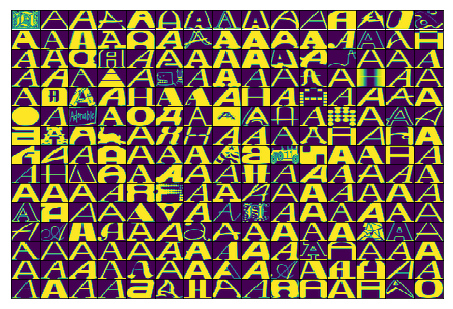

In [62]:
def show_letter_sample(letter_data, shape=(15, 15)):
    sample = [letter_data[x] for x in random.sample(range(len(letter_data)) , shape[0]*shape[1])]
    gs = gridspec.GridSpec(shape[0], shape[1], top=1.0, bottom=0., right=1.0, left=0., hspace=0., wspace=0.)

    for i, g in enumerate(gs):
        ax = plt.subplot(g)
        ax.imshow(sample[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('auto')

In [ ]:
data_d = {os.path.basename(x).split('.')[0]: pickle.load(open(x, 'rb')) for x in train_datasets}

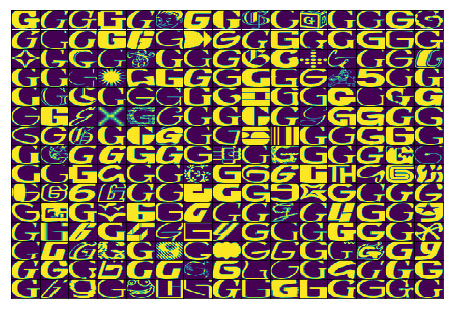

In [69]:
show_letter_sample(data_d['G'])

### Merge letters to single dataset

In [ ]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

### Shuffle Dataset

In [ ]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

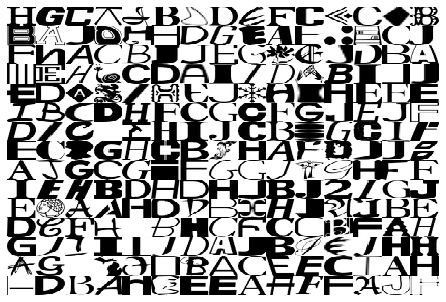

In [220]:
# check that data still looks good after randomize
show_letter_sample(train_dataset)

In [ ]:
data_root = r'C:\Kaggle\_noMNIST'
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

In [ ]:
# get data
data_root = r'C:\Kaggle\_noMNIST'
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

data_dict = pickle.load(open(pickle_file, 'rb'))
train_dataset = data_dict['train_dataset']
train_labels = data_dict['train_labels']
valid_dataset = data_dict['valid_dataset']
valid_labels = data_dict['valid_labels']
test_dataset = data_dict['test_dataset']
test_labels = data_dict['test_labels']

# Train - Logistic Regression (LR)

In [ ]:
# visualization of Logistic Regression coeficients
def viz_coef(coef):
    coef = coef.reshape((len(CLASSES), 28, 28))
    plt.figure(figsize=(12, 5))
    gs = gridspec.GridSpec(2, 5 )
    for i, g in enumerate(gs):
        ax = plt.subplot(g)
        ax.imshow(coef[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(CLASSES[i])
# viz_coef(lr_model.coef_)

### LR on different train size

In [ ]:
def log_regression(n_list):
    lr_model = LogisticRegression(penalty='l2', C=1.0, max_iter=100, verbose=10)
    test_x = test_dataset.reshape((len(test_dataset), 28*28))
    
    train_scores = []
    test_scores = []
    for n in n_list:
        train_x = train_dataset[:n].reshape((n, 28*28))
        # run model
        lr_model.fit(X=train_x, y=train_labels[:n])
        
        train_scores.append(lr_model.score(train_x, train_labels[:n]))
        test_scores.append(lr_model.score(test_x, test_labels))
        
    return train_scores, test_scores, n_list

In [ ]:
sns.set(font_scale=1.3)
sns.set_style("darkgrid")
def plot_scores(train_sc, test_sc, n):
    # create df
    df = pd.DataFrame({'train':train_sc, 'test':test_sc, 'n':n})
    plt.plot(n, train_sc, marker='s', label='train')
    plt.plot(n, test_sc, marker='o', label='test')
    plt.xlabel('Train Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Train and Test Accuracy')

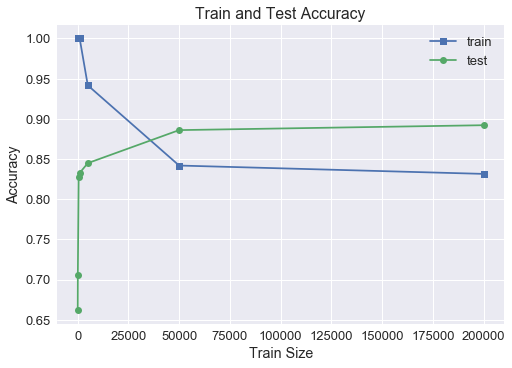

In [43]:
# plot
n = [50, 100, 500, 1000, 5000, 50000, 200000]
# tr_sc, te_sc, n = log_regression(n)
plot_scores(tr_sc, te_sc, n)

### LR model coeficents

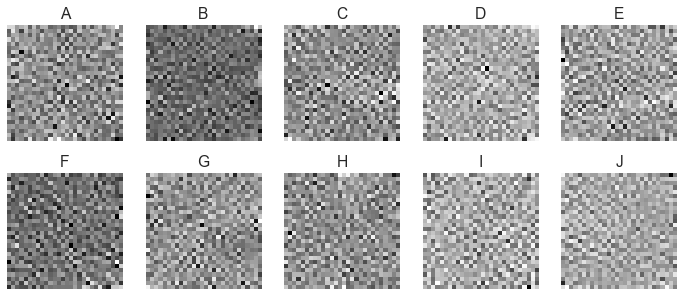

In [48]:
model_50k = LogisticRegression(penalty='l2', C=1.0, max_iter=100, verbose=10)
model_50k.fit(train_dataset[:50000].reshape((50000, 28*28)), train_labels[:50000])
viz_coef(model_50k.coef_)